## LFP Preprocessing

These are magics that provide certain functionality. Specifically, if you edit functions that are called in this notebook, the functions are reloaded so the changes propagate here without needing to reload the notebook.


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import warnings 
import scipy

# I only want to see warnings once
warnings.filterwarnings('ignore')

Note: If you have installed the LFPAnalysis package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

In [3]:
import sys
sys.path.append('/hpc/users/tostag01/LFPAnalysis/')

In [4]:
from LFPAnalysis_GT import SNT_utils, lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

## Pre-process (run 1x): 

In the pre-processing functions below, we: 

1. load the raw data (either a .edf file or a folder of .nlx files) into mne objects for use with the mne toolbox: https://mne.tools/stable/index.html.

2. load the localized electrode names from the .csv or .xlsx file listing their MNI coordinates into the mne object

3. filter and resample as necessary

4. re-reference 

In [103]:
# subj_ids = ['MS030', 'MS043', 'MS047', 'MS048', 'MS053']
# subj_ids = ['MS009', 'MS020', 'MS034', 'MS045', 'MS050']
# subj_ids = ['MS008','MS019', 'MS052', 'MS030', 'MS043', 'MS047', 'MS048', 'MS053', 'MS009', 'MS020', 'MS034', 'MS045', 'MS050']
subj_ids = ['MS019']
subj_sites = ['MSSM' for _ in subj_ids]
subj_formats = ['edf' for _ in subj_ids]
base_dir = '/sc/arion/projects/OlfMem/tostag01/SocialNav'

In [104]:
load_preproc_data = True
load_reref_data = True

In [105]:
for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    print(f'Working on subj {subj_id}')
    
    # Set paths
    if format == 'nlx':
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/nlx/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/nlx/'
    else:   
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/'
    
    elec_path = f'{base_dir}/data/{subj_id}/anat/'
    
    # Check if path exists for saving, and if not, make it
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # electrode files could either be csv or excel
    elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
    # There should really only be one, so grab it with the zero-index 
    elec_file = elec_files[0]
    
    ### Pre-process data
    if load_preproc_data:
        mne_data = mne.io.Raw(f'{save_path}raw_ieeg.fif', preload=True)
        
    else:
        # Make MNE file
        mne_data = lfp_preprocess_utils.make_mne(load_path=load_path, 
                                                 elec_path=elec_file,
                                                 format=format,
                                                 return_data=True,
                                                 site=site,
                                                 check_bad=False) # changed this to not annotate anything as bad 

        # Save this data so that you don't need this step again:
        mne_data.save(f'{save_path}/raw_ieeg.fif', overwrite=True)
        
    ### Bipolar re-reference data
    if load_reref_data:
        mne_data_reref = mne.io.read_raw_fif(f'{save_path}/ieeg_bp.fif', preload=True)
    else:
        # Re-reference neural data
        mne_data_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                                  elec_path=elec_file, 
                                                  method='bipolar', 
                                                  site=site)

        # Save this data so that you don't need this step again:
        mne_data_reref.save(f'{save_path}/ieeg_bp.fif', overwrite=True)

    # Should also save out re-referenced elec_file: 
    elec_data = lfp_preprocess_utils.load_elec(elec_file)
    anode_list = [x.split('-')[0] for x in mne_data_reref.ch_names]
    elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
    elec_df['label'] =  elec_df.label.apply(lambda x: [a for a in mne_data_reref.ch_names if str(x).lower() in a.split('-')[0]][0])

    # Add region to the data frame 

    manual_col = [col for col in elec_df.columns if 'manual' in col.lower()][0]
    all_regions = [] 
    for chan_name in elec_df.label.unique():
        elec_region = analysis_utils.select_rois_picks(elec_df, chan_name, manual_col=manual_col)
        all_regions.append(elec_region) 

    elec_df['SNT_region'] = all_regions
    elec_df['hemisphere'] = elec_df.label.apply(lambda x: x[0])

    elec_df.to_csv(f'{save_path}/labels_bp', index=False)


Working on subj MS019
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS019/LFP/raw_ieeg.fif...
Isotrak not found
    Range : 0 ... 1659187 =      0.000 ...  3318.374 secs
Ready.
Reading 0 ... 1659187  =      0.000 ...  3318.374 secs...
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS019/LFP//ieeg_bp.fif...
    Range : 0 ... 1659187 =      0.000 ...  3318.374 secs
Ready.
Reading 0 ... 1659187  =      0.000 ...  3318.374 secs...


 - mne_data: a Raw mne object, where the data has been loaded, filtered for line noise, parsed for different data types, and resampled if necessary. 
 
 - mne_data_reref: an mne object containing re-referenced data (either white matter or bipolar)

## NOW look at the data to manually remove channels: 

After bipolar referencing: 

In [10]:
%matplotlib notebook 

In [13]:
# Scroll up/down and left/right using your keyboard. CLICK on a channel to turn it 'grey' and mark as a 'bad' channel. 
# If you click a grey channel again it will unmark it. 

mne_data_reref = mne.io.read_raw_fif(f'{save_path}/ieeg_bp.fif', preload=True)
fig = mne_data_reref.plot(start=0, duration=120, n_channels=30, 
                      scalings=mne_data_reref._data.max()/30
                     )

Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS038/LFP//ieeg_bp.fif...
    Range : 0 ... 1346218 =      0.000 ...  2692.436 secs
Ready.
Reading 0 ... 1346218  =      0.000 ...  2692.436 secs...
Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>

In [14]:
# ALSO look at the power spectra! 
# You can click on channels here to identify them, and go back to the viz above to mark them as noise if need be

mne_data_reref.compute_psd().plot()

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 - mne_dict: a dictionary containing all of your subjects' re-referenced mne data 
 
 - photodiode_dict: a dictionary containing all of your subjects' photodiode data 
 
 - elec_dict: a dictionary containing the paths to your subjects' electrode data 

## Sync behavioral and neural data

Here, we perform a critical step: computing the time offset between the computer that recorded the neural data and the laptop that featured the experiment. 

The function here only requires a **subset** of detected sync signals (i.e. photodiode deflections) to be detected to successfully compute this offset. 

First, you may need to MANUALLY clean the photodiode signal if the recording quality is poor. Load it, plot it, and try to isolate/amplify the pulses. 

Working on subj MS019
13 responses missed for MS019
There are 63 behav syncs detected
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/data/MS019/raw/neural/photodiode.fif...
Isotrak not found
    Range : 0 ... 3398015 =      0.000 ...  3318.374 secs
Ready.
Reading 0 ... 3398015  =      0.000 ...  3318.374 secs...
There are 68 neural syncs detected
Max rval with slope of 1.000180750869814 and offset of -4.048653441513906


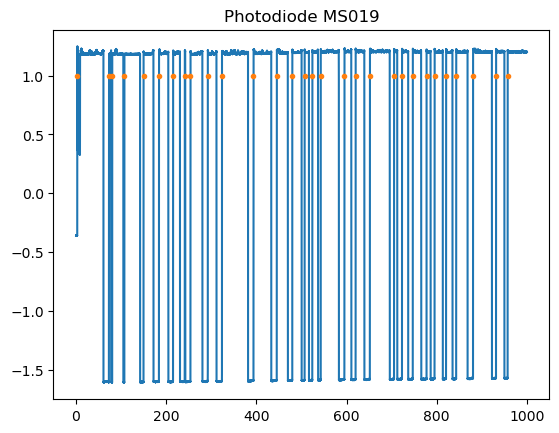

In [106]:
slopes = {f'{x}': [] for x in subj_ids}
offsets = {f'{x}': [] for x in subj_ids}

for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    print(f'Working on subj {subj_id}')
    
    # Set paths
    if format == 'nlx':
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/nlx/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/nlx/'
    else:   
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/'

    behav_path = f'{base_dir}/data/{subj_id}/raw/behav/'
    log_file = glob(f'{behav_path}/*.log')[0]
    time_df = SNT_utils.parse_logfile(log_file)
    time_df.to_csv(f'{base_dir}/preproc/{subj_id}/behav/time_df.csv', index=False)
    missing_responses = time_df[(time_df['decision_trial_start'].notna()) & (time_df['rt'] == 0)]
    print(f'{missing_responses.shape[0]} responses missed for {subj_id}')

    beh_ts = time_df['decision_trial_start'].values
    beh_ts = beh_ts[~np.isnan(beh_ts)]
    print(f'There are {len(beh_ts)} behav syncs detected')
    
    # Synchronize to the photodiode or whatever your neural sync signal is
    if subj_id == 'MS038':
        photodiode_data = mne.io.read_raw_fif(f'{save_path}clean_photodiode.fif', preload=True)
        photodiode_data._data = photodiode_data._data[:,600000:]
        smoothSize=35 
        windSize=20
        height=5.6       
        
    elif subj_id == 'MS034':
        photodiode_data = mne.io.read_raw_fif(f'{load_path}photodiode.fif', preload=True)
        photodiode_data._data = photodiode_data._data[:,:1750000]
        smoothSize=15
        windSize=15
        height=0.3

    elif subj_id == 'MS042':
        photodiode_data = mne.io.read_raw_fif(f'{load_path}photodiode.fif', preload=True)
        photodiode_data._data = photodiode_data._data[:,:1800000]
        smoothSize=15
        windSize=15
        height=0.3
        
        
    else:
        photodiode_data = mne.io.read_raw_fif(f'{load_path}photodiode.fif', preload=True)
        if subj_id == 'MS054':
            photodiode_data._data *= -1 #invert
        smoothSize=15
        windSize=15
        height=0.3

#     try:
#         slope, offset = sync_utils.synchronize_data(beh_ts, 
#                             photodiode_data, 
#                             smoothSize=11, windSize=15,
#                             height=0.8)
        
#     except Exception:
#         try:
#             print("fast and robust sync failed - trying simple sync now")
#             slope, offset = SNT_utils.synchronize(beh_ts, photodiode_data, subj_id, smoothSize, windSize, height)
#         except Exception as e:
#             raise RuntimeError("Both synchronization methods failed. Please review parameters.") from e
    
    try:
        slope, offset = SNT_utils.synchronize(beh_ts, photodiode_data, subj_id, smoothSize, windSize, height)
    except Exception as e:
        raise RuntimeError("Sync failed. Please review parameters or try another method") from e

    slopes[subj_id].append(slope)
    offsets[subj_id].append(offset)
    


 - slopes: a dictionary containing the slopes (should be ~ 1) for each subject
 - offsets: a dictionary containing the offsets for each subject

### If troubleshooting photodiode

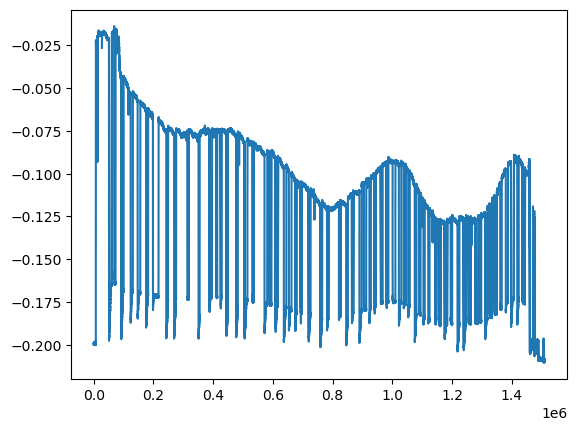

In [57]:
photodiode_data._data *= -1
plt.plot(photodiode_data._data[0,0:1540000])
plt.show()

Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/data/MS043/raw/neural/photodiode.fif...
Isotrak not found
    Range : 0 ... 2227007 =      0.000 ...  2174.812 secs
Ready.
Reading 0 ... 2227007  =      0.000 ...  2174.812 secs...
There are 65 neural syncs detected
[0.99971606 0.99971126 0.99951606]
Max rval 0.9997160634240606 with slope of 1.015335675175666 and offset of -4.353320475658222


Text(0.5, 1.0, 'Photodiode MS043')

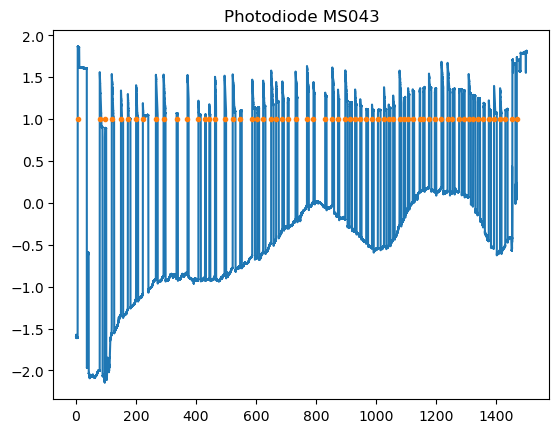

In [101]:
subj_id = 'MS043'
load_path = f'{base_dir}/data/{subj_id}/raw/neural/'
photodiode_data = mne.io.read_raw_fif(f'{load_path}photodiode.fif', preload=True)
photodiode_data._data = photodiode_data._data[:,0:1540000]
    

# # #to invert 
# photodiode_data._data *= -1


smoothSize=40
windSize=50
height=0.6

sig = np.squeeze(sync_utils.moving_average(photodiode_data._data, n=smoothSize))
timestamp = np.squeeze(np.arange(len(sig))/photodiode_data.info['sfreq'])
sig = scipy.stats.zscore(sig)
trig_ix = np.where((sig[:-1]<=height)*(sig[1:]>height))[0] # rising edge of trigger

neural_ts = timestamp[trig_ix]
neural_ts = np.array(neural_ts)
print(f'There are {len(neural_ts)} neural syncs detected')

nwin = len(neural_ts) - len(beh_ts)
rvals = []
slopes = [] 
offsets = []
for i in range(nwin+1):
    slope, offset, rval = sync_utils.sync_matched_pulses(np.array(beh_ts), neural_ts[i:len(beh_ts)+i])
    rvals.append(rval)
    slopes.append(slope)
    offsets.append(offset)
rvals = np.array(rvals)
offsets = np.array(offsets)
slopes = np.array(slopes)
print(rvals)
slope=slopes[np.argmax(rvals)]
offset=offsets[np.argmax(rvals)]
print(f'Max rval {np.max(rvals)} with slope of {slope} and offset of {offset}')

sig_indices = [index for index,value in enumerate(timestamp) if value > 0 and value < 2000]
neu_indices = [index for index,value in enumerate(neural_ts) if value > 0 and value < 2000]
plt.figure()
plt.plot(timestamp[sig_indices], sig[sig_indices])
plt.plot(neural_ts[neu_indices], np.ones_like(neural_ts[neu_indices]), 'o', markersize=3)
plt.title("Photodiode " + subj_id)

## Load your behavioral data & Epoch

Notes:

I also segment a baseline period for every event of interest.

I apply a buffer period of 1.0 seconds - this will be helpful when we compute spectrograms later.

The IED count for every channel is added to the epoch metadata

In [8]:
# slopes = {'MS030': [1.0137373699396954],
#   'MS043': [1.015339681661327],
#   'MS047': [0.9999853492053359],
#   'MS048': [0.9905465104641955],
#   'MS053': [0.999557181292875]}
# offsets = {'MS030': [48.26914492235858],
#   'MS043': [-4.345857671888837],
#   'MS047': [-101.66525322713656],
#   'MS048': [795.4234345224513],
#   'MS053': [-6.683276434495724]}

In [23]:
choice_df[choice_df['button_press'] != 0]

,decision_num,char_decision_num,scene_num,dimension,char_role_num,onset,button_press,decision,affil,power,...,y,r_current,r_new,angle_current,angle_new,decision_id,raw_angle,raw_angle_new,cosine_current,cosine_new
1,2,2,1,affil,1,90.748672,2,1,1,0,...,0,6.000000,5.000000,0,0,0,1.570796,1.570796,0.000000,0.000000
2,3,3,1,affil,1,117.812355,1,1,1,0,...,0,5.000000,4.000000,0,0,0,1.570796,1.570796,0.000000,0.000000
3,4,4,2,power,1,154.952225,2,-1,0,-1,...,-1,4.000000,4.123106,0,0,1,1.570796,1.815775,0.000000,-0.242536
5,6,2,2,power,2,217.617218,2,-1,0,-1,...,-1,6.000000,6.082763,0,0,1,1.570796,1.735945,0.000000,-0.164399
6,7,5,3,power,1,243.502350,2,1,0,1,...,0,4.123106,4.000000,0,0,1,1.815775,1.570796,-0.242536,0.000000
7,8,6,3,affil,1,255.546295,1,1,1,0,...,0,4.000000,3.000000,0,0,0,1.570796,1.570796,0.000000,0.000000
12,13,8,5,power,1,482.603821,2,-1,0,-1,...,-1,3.000000,3.162278,0,0,1,1.570796,1.892547,0.000000,-0.316228
13,14,9,5,power,1,513.219666,2,1,0,1,...,0,3.162278,3.000000,0,0,1,1.892547,1.570796,-0.316228,0.000000
14,15,1,5,neutral,9,529.523682,1,0,0,0,...,0,6.000000,6.000000,0,0,1,1.570796,1.570796,0.000000,0.000000
15,16,2,5,neutral,9,549.624939,2,0,0,0,...,0,6.000000,6.000000,0,0,1,1.570796,1.570796,0.000000,0.000000


In [78]:
time_df.iloc[137,:]

trial                             138
non_decision_trial_start          NaN
space_press_time                  NaN
decision_trial_start        1256.5113
choice_start                      NaN
rt                                0.0
key_pressed                       2.0
photodiode                  white.png
Name: 137, dtype: object

In [77]:
time_df.iloc[137, time_df.columns.get_loc('key_pressed')] = 2.0


In [109]:
choice_df[choice_df.button_press == 2]

,decision_num,char_decision_num,scene_num,dimension,char_role_num,onset,button_press,decision,affil,power,...,y,r_current,r_new,angle_current,angle_new,decision_id,raw_angle,raw_angle_new,cosine_current,cosine_new
1,2,2,1,affil,1,90.748672,2,1,1,0,...,0,6.000000,5.000000,0,0,0,1.570796,1.570796,0.000000,0.000000
3,4,4,2,power,1,154.952225,2,-1,0,-1,...,-1,4.000000,4.123106,0,0,1,1.570796,1.815775,0.000000,-0.242536
5,6,2,2,power,2,217.617218,2,-1,0,-1,...,-1,6.000000,6.082763,0,0,1,1.570796,1.735945,0.000000,-0.164399
6,7,5,3,power,1,243.502350,2,1,0,1,...,0,4.123106,4.000000,0,0,1,1.815775,1.570796,-0.242536,0.000000
12,13,8,5,power,1,482.603821,2,-1,0,-1,...,-1,3.000000,3.162278,0,0,1,1.570796,1.892547,0.000000,-0.316228
13,14,9,5,power,1,513.219666,2,1,0,1,...,0,3.162278,3.000000,0,0,1,1.892547,1.570796,-0.316228,0.000000
15,16,2,5,neutral,9,549.624939,2,0,0,0,...,0,6.000000,6.000000,0,0,1,1.570796,1.570796,0.000000,0.000000
17,18,5,6,power,2,623.392273,2,1,0,1,...,0,6.082763,6.000000,0,0,1,1.735945,1.570796,-0.164399,0.000000
20,21,3,6,power,4,725.328247,2,1,0,1,...,1,6.000000,6.082763,0,0,1,1.570796,1.405648,0.000000,0.164399
23,24,6,7,power,4,799.268555,2,-1,0,-1,...,1,6.324555,6.082763,0,0,1,1.249046,1.405648,0.316228,0.164399


In [89]:
# time_df[(time_df['key_pressed'] == 1) & (time_df['key_pressed'].notna())]

In [111]:
time_df[(time_df['key_pressed'] == 2) & (time_df['key_pressed'].notna())]

,trial,non_decision_trial_start,space_press_time,decision_trial_start,choice_start,rt,key_pressed,photodiode
6,7,NaN,NaN,91.0861,93.5303,2.4442,2.0,white.png
12,13,NaN,NaN,155.3201,163.0057,7.6856,2.0,white.png
18,19,NaN,NaN,217.9495,228.4642,10.5147,2.0,white.png
21,22,NaN,NaN,243.8376,254.4512,10.6136,2.0,white.png
26,27,NaN,NaN,293.5051,305.5847,12.0796,2.0,white.png
50,51,NaN,NaN,482.9642,492.9210,9.9568,2.0,white.png
54,55,NaN,NaN,513.5928,520.2575,6.6647,2.0,white.png
59,60,NaN,NaN,549.9892,556.0085,6.0193,2.0,white.png
68,69,NaN,NaN,623.7364,633.3645,9.6281,2.0,white.png
84,85,NaN,NaN,725.6636,736.2245,10.5609,2.0,white.png


In [76]:
time_df[time_df['rt'] > 12]

,trial,non_decision_trial_start,space_press_time,decision_trial_start,choice_start,rt,key_pressed,photodiode
26,27,NaN,NaN,293.5051,305.5847,12.0796,2.0,white.png


In [107]:
for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    slope = slopes[subj_id][0]
    offset = offsets[subj_id][0]
    print(f'Working on subj {subj_id} with slope {slope} and offset {offset}')
    
    # Set paths
    if format == 'nlx':
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/nlx/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/nlx/'
    else:   
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/'
    
    behav_path = f'{base_dir}/preproc/{subj_id}/behav/'
    elec_path = f'{base_dir}/data/{subj_id}/anat/'
    
    choice_file = glob(f'{behav_path}choice_df_all.csv')[0]
    log_file = glob(f'{behav_path}time_df.csv')[0]
    choice_df = pd.read_csv(choice_file)
    time_df = pd.read_csv(log_file)
    
    buf = 1.0 # this is the buffer before and after that we use to limit edge effects for TFRs

    IED_args = {'peak_thresh':5,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

    # Define epochs of interest according to timestamps from behavior df 
    epochs_list = ['options_slide', 'decision_time', 'narration_slide', 'ITI']
    behav_times = {f'{x}': [] for x in epochs_list}
    behav_times['baseline'] = time_df['decision_trial_start'].dropna().tolist()
    behav_times['decision_time'] = time_df['choice_start'].dropna().tolist()
    behav_times['ITI'] = time_df['choice_start'].dropna().tolist()
    behav_times['narration_slide'] = time_df['space_press_time'].dropna().tolist()


    # Create a dictionary with your event name (matching your dataframe), and the time-window for the event
    evs = {'decision_time': [-1.5, 0], #ChoiceOnset
           'narration_slide': [-1.5, 0], # narration slide
           'ITI': [0, 0.5],  # ITI
           'baseline': [-0.5, 0],  # baseline, few ms before options slide
          }

    buf = 1.0  # this is the buffer before and after that we use to limit edge effects for TFRs
    epochs_all_evs = {f'{x}': np.nan for x in evs}

    
    for event in evs.keys():
        pre = evs[event][0]
        post = evs[event][1]
        fixed_baseline = None

        if event == 'narration_slide' and subj_id == 'MS048':
            behav_times['narration_slide'] = time_df['non_decision_trial_start'].dropna() - 0.45

        # THE following function will now SAVE out dataframes that indicate IED and artifact time points in your data
        epochs = lfp_preprocess_utils.make_epochs(load_path=f'{save_path}ieeg_bp.fif', 
                                                  slope=slope, offset=offset, 
                                                  behav_name=event, behav_times=behav_times[event],
                                                  ev_start_s=pre, ev_end_s=post, buf_s=buf, downsamp_factor=None, IED_args=IED_args, detrend=0)


        epochs_all_evs[event] = epochs
        
        if event in ['decision_time', 'ITI']:
            print(f'Adding metadata for subj {subj_id} to {event} epoch')
            behav_params = ['decision_num', 'char_decision_num', 'scene_num', 'dimension',
               'char_role_num', 'onset', 'button_press', 'decision', 'affil', 'power',
               'reaction_time', 'char', 'decision_axis', 'x', 'y', 'r_current',
               'r_new', 'angle_current', 'angle_new', 'decision_id', 'raw_angle',
               'raw_angle_new', 'cosine_current', 'cosine_new']

            event_metadata = pd.DataFrame(columns=behav_params)
            choice_df_clean = choice_df[choice_df['button_press'] != 0]
            
            for param in behav_params:
                if param in choice_df_clean.columns:
                    event_metadata[param] = choice_df_clean[param].tolist()
                else:
                    print(f"Warning: Parameter {param} not found in choice_df. Filling with NaNs.")
                    event_metadata[param] = np.nan

            # validate metadata alignment
            if len(event_metadata) != len(epochs.events):
                raise ValueError(f"Metadata length ({len(event_metadata)}) does not match number of epochs ({len(epochs.events)}) for {event}")

                
            epochs_all_evs[event].metadata = event_metadata
            
        epochs_all_evs[event].save(f'{save_path}/{event}-epo.fif', overwrite=True)



Working on subj MS019 with slope 1.000180750869814 and offset -4.048653441513906
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS019/LFP/ieeg_bp.fif...
    Range : 0 ... 1659187 =      0.000 ...  3318.374 secs
Ready.
Reading 0 ... 1659187  =      0.000 ...  3318.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   13.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    7.0s finished


Used Annotations descriptions: ['decision_time']
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 50 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata for subj MS019 to decision_time epoch


ValueError: Metadata length (48) does not match number of epochs (50) for decision_time

### Plot and examine the epochs if you'd like:

In [73]:
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

In [74]:
# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')